#### Goal - Calculate the purity as a function of cut in the sample

## 0. Import packages / Constants

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tqdm import tqdm
import sys,os

MEDULLA_DIR = '/exp/sbnd/app/users/brindenc/develop/medulla_area/medulla'

sys.path.append(MEDULLA_DIR)

plt.style.use('/exp/sbnd/app/users/brindenc/develop/medulla_area/medulla/spineplot/styles/numu2025.mplstyle')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
SBRUCE_FILE = '/exp/sbnd/data/users/brindenc/medulla/test/numucc_incl_sys2.root'
OUTPUT_DIR = '/exp/sbnd/data/users/brindenc/medulla/test/tmp2'

## 1. Load data + extract variables

In [24]:
tree_nu = uproot.open(SBRUCE_FILE)['events/simulation;1']#/selected1muXNu_none;1']
tree_cos = uproot.open(SBRUCE_FILE)['events/simulation;1']#/selected1muXCos_none;1']
tree_offbeam = uproot.open(SBRUCE_FILE)['events/data_offbeam;1']#/selected1muXCos_none;1']
tree_data = uproot.open(SBRUCE_FILE)['events/data;1']#/selected1muXCos_none;1']

#Normalize by livetime since off-beam has no POT
livetime_nu, pot_nu = tree_nu['Livetime;1'].values()[0], tree_nu['POT;1'].values()[0]
livetime_cos, pot_cos = tree_cos['Livetime;1'].values()[0], tree_cos['POT;1'].values()[0]
livetime_offbeam, pot_offbeam = tree_offbeam['Livetime;1'].values()[0], tree_offbeam['POT;1'].values()[0]
livetime_data, pot_data = tree_data['Livetime;1'].values()[0], tree_data['POT;1'].values()[0]

#Normalize everything to data (use livetime for off-beam since there's no POT)
weight_nu, weight_cos = 1., 1.
weight_data = pot_data/pot_nu
weight_offbeam = livetime_data/livetime_offbeam * 1/weight_data
weights = [weight_nu, weight_cos, weight_offbeam] #Exclude data from purity calculation

In [25]:
pot_nu,pot_data

(np.float64(7.523829744643604e+17), np.float64(4.5775537265536983e+18))

In [27]:
keys = ['reco_leading_muon_momentum',
  'reco_leading_muon_costheta',
  'reco_vertex_x',
  'true_leading_muon_momentum',
  'true_leading_muon_costheta',
  'true_vertex_x',
  'true_category']
cut_dict = {
  'reco_valid_flashmatch': 'Flash Match',
  'reco_fiducial_bool': 'Fiducial',
  'reco_has_muon_bool': 'Has Muon',
  'reco_leading_muon_start_dedx_bool': 'Start dE/dx',
  'reco_flash_score_bool': 'Flash Score'}
#keys = keys + list(cut_dict.keys())
cut_names = ['None'] + list(cut_dict.keys()) #Add none to beginning

df = tree_nu['selected1muX;1'].arrays(keys, library='pd')
df_nu = tree_nu['selected1muXNu_none;1'].arrays(keys, library='pd')
df_cos = tree_cos['selected1muXCos_none;1'].arrays(keys, library='pd')
df_offbeam = tree_offbeam['selected1muXNu_none;1'].arrays(keys, library='pd')
df_offbeam['true_category'] = 7 #override to cosmic category
df_data = tree_data['selected1muXNu_none;3'].arrays(keys, library='pd')

dfs = [df_nu, df_cos, df_offbeam] #Exclude data for purity calculation

df.head(10)

,reco_leading_muon_momentum,reco_leading_muon_costheta,reco_vertex_x,true_leading_muon_momentum,true_leading_muon_costheta,true_vertex_x,true_category
0,1428.117687,0.991325,-30.600006,1155.281454,0.992448,-31.601196,1.0
1,780.023360,0.891186,-72.350006,779.853253,0.905027,-72.786499,1.0
2,342.309390,0.049923,142.449997,331.689698,0.088981,142.684357,0.0
3,429.780678,0.247631,-43.950012,416.486078,0.219217,-44.482025,0.0
4,231.829553,-0.032255,99.449997,229.568034,-0.064637,100.288452,0.0
5,165.293597,0.113855,-99.449997,167.790695,0.220913,-100.119431,0.0
6,545.947957,0.965906,179.550018,503.022569,0.965395,179.261200,0.0
7,518.678725,0.898120,-8.599994,572.277117,0.876643,-9.281677,0.0
8,397.786937,-0.283479,30.200001,391.196907,0.314893,-14.707245,0.0
9,195.910131,-0.152220,25.849979,258.241213,-0.093211,27.449158,0.0


In [29]:
#Find fraction of reco->true that are Nan
np.sum(df.true_category.isna()),len(df)

(np.int64(78), 3051)

In [15]:
df.true_vertex_x.isna()

0          True
1         False
2         False
3         False
4         False
          ...  
101548    False
101549    False
101550    False
101551    False
101552    False
Name: true_vertex_x, Length: 101553, dtype: bool

## 2. Compute purity

In [8]:
def get_purities(dfs, weights, cut_names, category_inds=[0,1]):
    """
    Return the purities for a given set of cuts and categories.

    Parameters
    ----------
    dfs : list of pandas.DataFrame
        List of dataframes to compute the purities for. The dfs are
        different samples.
    weights : list of float
        List of weights for each dataframe.
    cut_names : list of str
        List of cut names to compute the purities for.
    category_inds : list of int, optional
        List of category indices to compute the purities for.

    Returns
    -------
    purities : dict
        Dictionary of purities for each cut.
    """
    _dfs = [df.copy() for df in dfs]
    purities = {}
    for cut_name in cut_names:
      n_sig, n_bkg = 0., 0.
      for _df, weight in zip(_dfs, weights):
        if cut_name == 'None':
          cut_bool = [True] * len(_df)
          n_sig += _df[_df['true_category'].isin(category_inds)].shape[0]*weight
          n_bkg += _df[~_df['true_category'].isin(category_inds)].shape[0]*weight
        else:
          n_sig += _df[_df['true_category'].isin(category_inds)][cut_name].sum()*weight
          n_bkg += _df[~_df['true_category'].isin(category_inds)][cut_name].sum()*weight
      purities[cut_name] = n_sig / (n_sig + n_bkg)
      if cut_name != 'None':
        _dfs = [_df[_df[cut_name].astype(bool)] for _df in _dfs]
    return purities

In [9]:
purities = get_purities(dfs, weights, cut_names)
cut_purity_dict = {}
for cut_name, purity in purities.items():
  if cut_name != 'None':
    cut_purity_dict[cut_name] = [cut_dict[cut_name], f"{purity*100:.1f}%"]
  else:
    cut_purity_dict[cut_name] = ['No cut', f"{purity*100:.1f}%"]
cut_purity_dict

{'None': ['No cut', '3.7%'],
 'reco_valid_flashmatch': ['Flash Match', '28.8%'],
 'reco_fiducial_bool': ['Fiducial', '55.9%'],
 'reco_has_muon_bool': ['Has Muon', '73.6%'],
 'reco_leading_muon_start_dedx_bool': ['Start dE/dx', '81.5%'],
 'reco_flash_score_bool': ['Flash Score', '89.9%']}

## 3. Make a pretty table

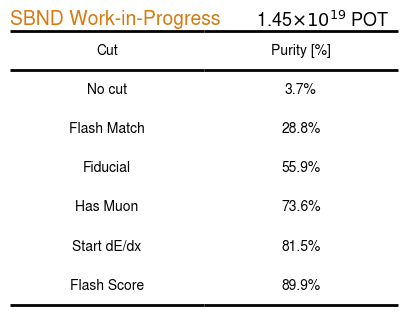

In [10]:
from spineplot.utilities import mark_pot, mark_preliminary

def create_purity_table(cut_dict_purity, ax):
    """
    Create a pretty table for purity data similar to the efficiency table format.
    
    Parameters
    ----------
    cut_dict_purity : dict
        Dictionary with cut keys and [label, purity] values
    ax : matplotlib.axes.Axes
        The axis to draw the table on
    title : str
        Title for the table
    """
    # Clear the axis for table display
    ax.axis('off')
    
    # Create the table data
    cuts = []
    purities = []
    
    for cut_key, (label, purity) in cut_dict_purity.items():
        cuts.append(label)
        purities.append(purity)
    
    # Create DataFrame
    results = pd.DataFrame({
        'Cut': cuts,
        'Purity [%]': purities
    })
    
    # Create table data
    table_data = [results.columns.to_list()] + results.values.tolist()
    
    # Create the table
    table = ax.table(cellText=table_data, colLabels=None, loc='center', 
                    cellLoc='center', edges='T')
    table.scale(1, 2.75)
    
    # Style the table edges
    for i in range(2, len(table_data)):
        if i == len(table_data) - 1:
            # Bottom row gets bottom edge
            for j in range(len(table_data[i])):
                table[i, j].visible_edges = 'B'
        else:
            # Other rows get no edges except for group separators
            for j in range(len(table_data[i])):
                table[i, j].visible_edges = 'open'
    
    # Auto-scale the table to fit
    def calc_bbox_yext(obj):
        figure = plt.gcf()
        bbox = obj.get_window_extent(renderer=figure.canvas.get_renderer())
        p0, p1 = figure.transFigure.inverted().transform(bbox)
        return p1[1] - p0[1]

    scale = 2.75
    while calc_bbox_yext(table) > 0.92:
        table.scale(1, 1/scale)
        scale -= 0.05
        table.scale(1, scale)
    
    if scale < 2.0:
        print(f'Warning: Table with title `{title}` is too large to fit on the figure (scale = {scale:.2f}). Consider extending the figure vertically.')
    
    mark_preliminary(ax,'SBND Work-in-Progress',y=1.12)
    mark_pot(ax,pot_nu,vadj=0.1,horizontal=True)

    return table

# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Create the table
table = create_purity_table(cut_purity_dict, ax)

fig.savefig(os.path.join(OUTPUT_DIR,'pur_table.png'),dpi=300,bbox_inches='tight')